# Biweekly Report 6
**Spencer Shortt**

For this weeks report, we will practice using and visualizing semantic segmantation in tensorflow. The goal of segmantation is similar to that of object detection. We want to analyze an image to figure out which pixels belong to the object we are trying to classify. For example, we would like to identify which pixels of an image belong to a cat and visualize them in a clear way.
I refer anyone interested to this video: https://www.youtube.com/watch?v=CG7UJIEl7KI


This report is largely a tutorial from the tensorflow website: https://www.tensorflow.org/tutorials/images/segmentation

We will be looking at images of pets for classification purposes. The deep learning model we use is similar ot U-Net which uses a pretrained MobileNetV2 model as an encoder. U-Net can be read about here: https://arxiv.org/abs/1505.04597

For each image, we create "masks" which basically segments an image by classifying pixels as one of the following: 0 - pixel belonging to the pet; 1 - pixel bordering the pet; 2 - a surrounding pixel. We can then visualize these masks and try to predict the masks of our test data set using the deep learning model.


We begin by importing our libraries, which is mostly just tensorflow. We pull our dataset from tfds.

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:

!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-58ph2s5f
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-58ph2s5f


We then load the dataset:

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Next we need to normalize our data and fix our mask classification to give us labels $\{0,1,2\}$ instead of $\{1,2,3\}$:

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Here we initialize some of the parameters we will need for our model:

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

The dataset already comes split between train and test sets, so we simply need to assign variables to make them easier to call and alter if necessary.

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


Next we're going to add some simple augmentation to the images of the form of random flipping. There's aa tutorial about augmentation here that is worth skimming, but a quick reason is that it will add diversity to our dataset.
https://www.tensorflow.org/tutorials/images/data_augmentation


In [7]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Next we prepare the batches for our model:

In [8]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Below is the display function for visualization purposes, which is demonstrated in the code block following this one:

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

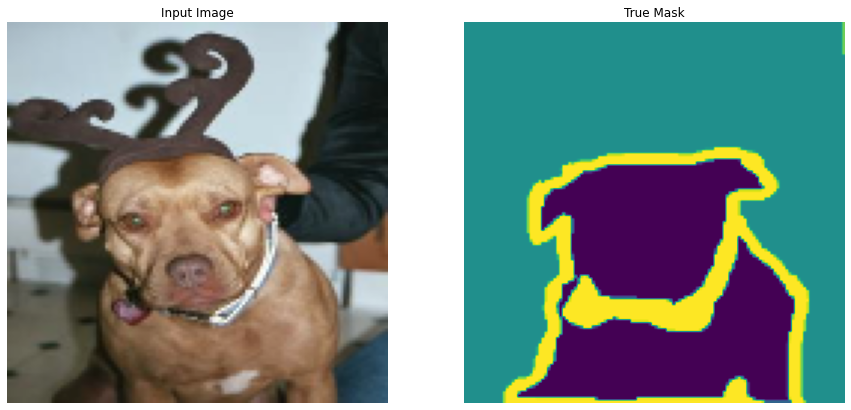

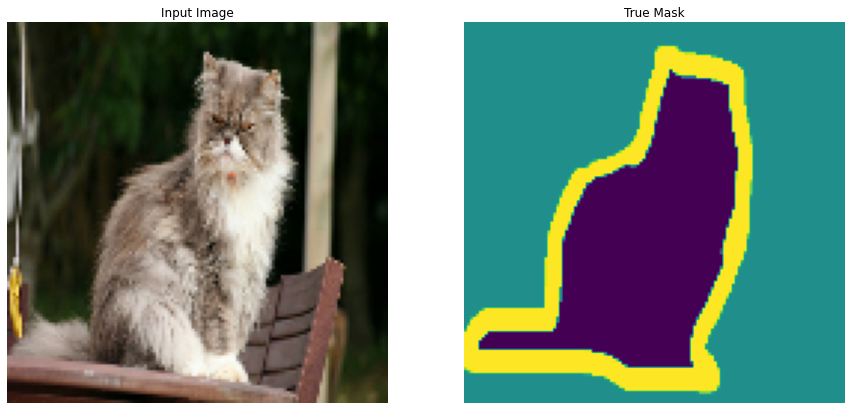

In [10]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

Now its time to create our MobileNetV2 model. This can be altered depending on what your input data looks like and what layers you want in your CNN. 

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

Next we do some basic upsampling before creating our U-Net model, which uses the above MobileNetV2 model for feature extraction.

In [12]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We use 'adam' for our optimization above and sparse categorical crossentropy for our loss function. A nice diagram of the model is printed below:

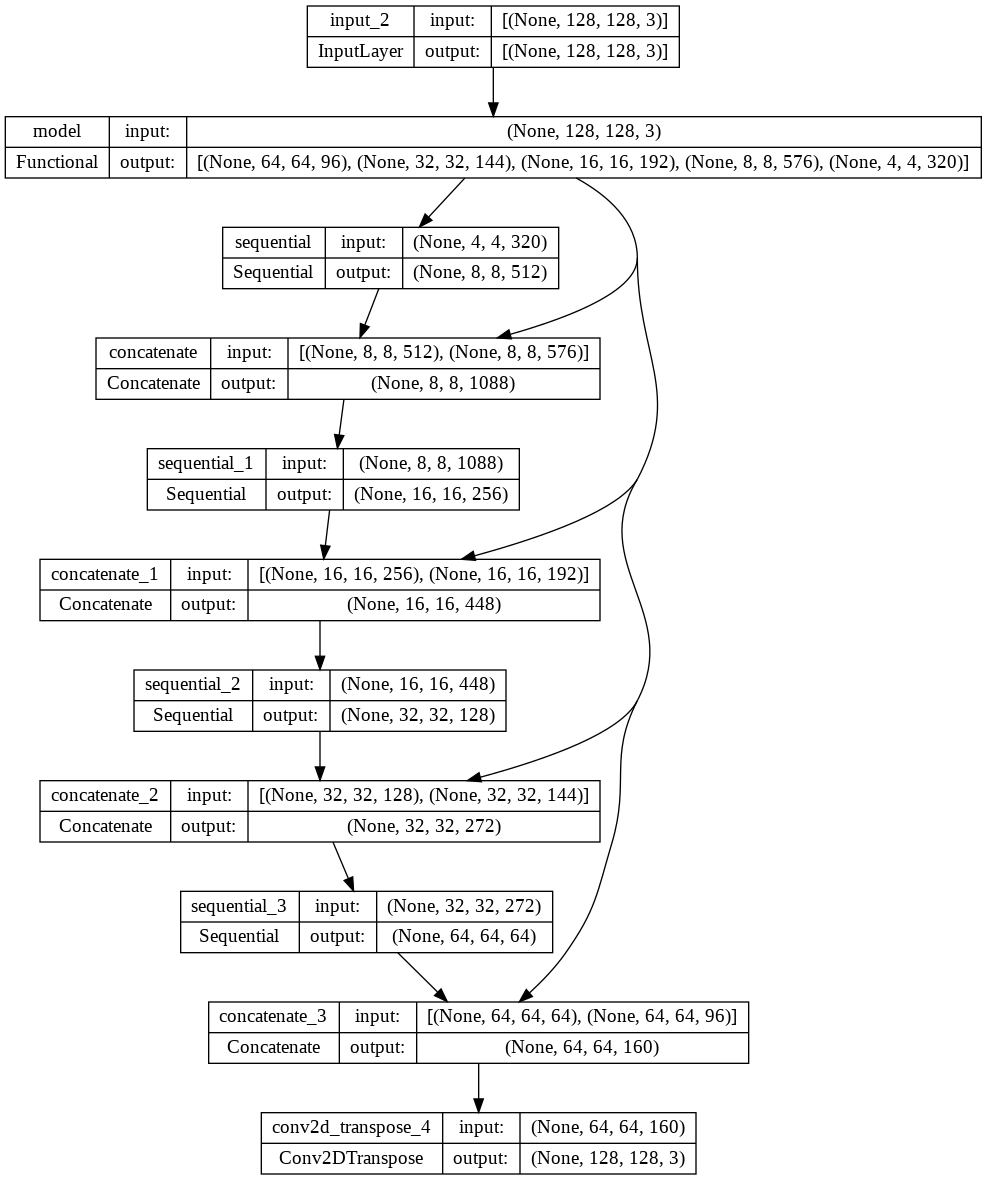

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

Now we create our masks (notice why it was important to get our classes into more of an array index form because of the agrmax). We also make a function to display our image, mask and the mask prediction.

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [17]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


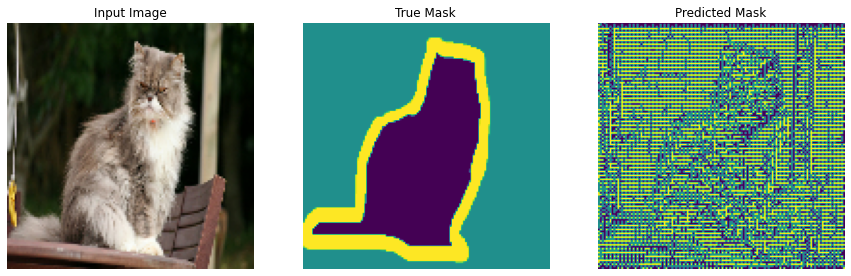

In [18]:
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Below we train our U-Net model using our training data and analyze the accuracy on the test dataset. Each run took surprisingly long to run, so we do our best with 3 epochs.

1/1 [==============================] - 0s 69ms/step


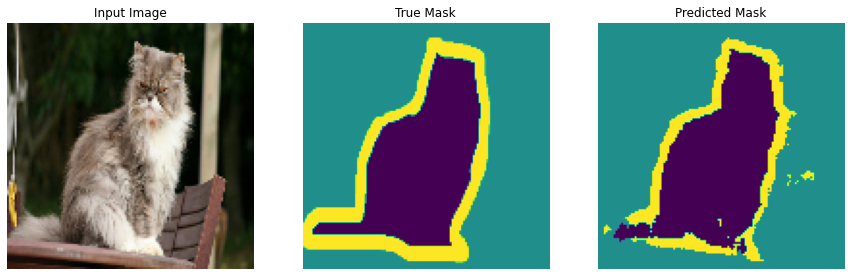


Sample Prediction after epoch 3

57/57 [==============================] - 329s 6s/step - loss: 0.2734 - accuracy: 0.8866 - val_loss: 0.2872 - val_accuracy: 0.8849


In [20]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Below we plot the loss on the validation set. The model performs very well on this dataset, as can be seen by the accuracies above as well.

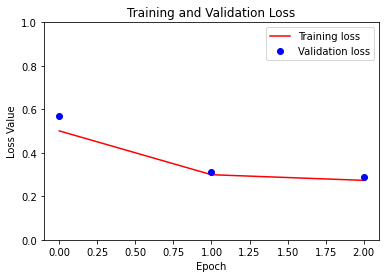

In [21]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Finally, we use our prediction function from earlier to visualize the predicted mask.

2/2 [==============================] - 3s 1s/step


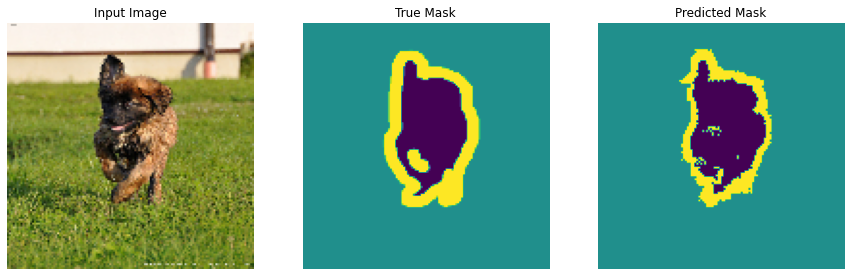

2/2 [==============================] - 3s 1s/step


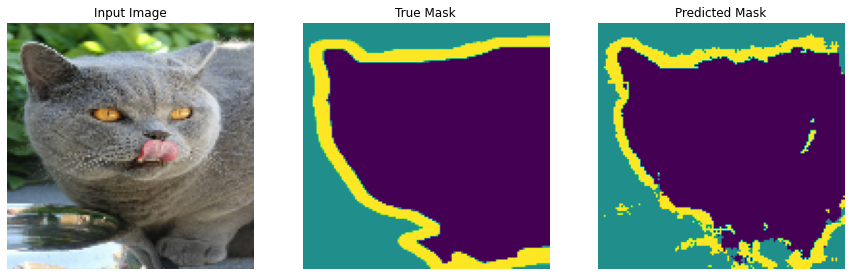

2/2 [==============================] - 3s 1s/step


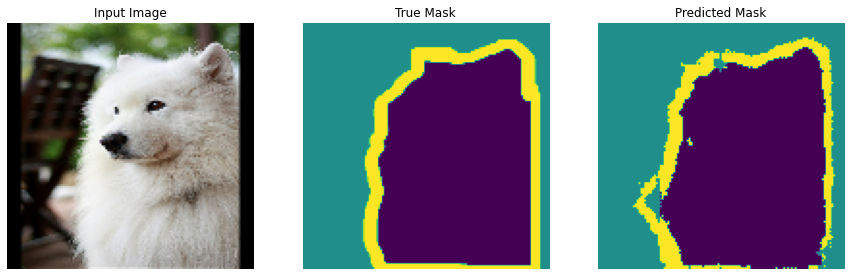

In [22]:
show_predictions(test_batches, 3)

# Conclusion
This report was trying to explore how to actually implement semantic segmentation in a nice and friendly setting. With more time, I would have liked to explore the U-Net model in more depth, but the purose of this report was more about how to actually segment images practically. I also tried changing the dataset to images with lower resolution to see how that would affect the results, but I ended up getting a lot of errors with the CIFAR-10 dataset and was unable to resolve them in time. This is something I would like to explore in the future. Overall, image segmentation is super cool. 

Thanks for reading!